Libraries loaded.
Data Loaded: (40076, 15)
Encoded Data Shape: (40076, 18)

=== Analysis 1: Propensity Score Analysis ===


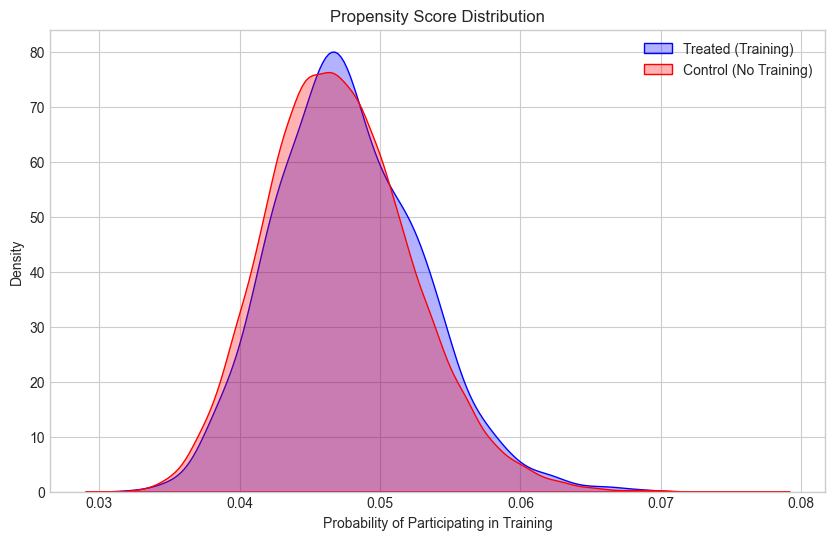

推定された因果効果 (ATE): -0.0041
解釈: 研修に参加することで、離職率は 約 -0.41% ポイント変化する

=== Analysis 2: Heterogeneity with Causal Forest ===
Calculating individual treatment effects (CATE)... This may take 1-2 minutes.

--- 研修効果が高い層 (Top Beneficiaries) ---


,age,job_family,performance_score,cate
2576,35,Engineering,1,-0.285472
7479,38,Engineering,1,-0.168615
2392,45,Engineering,1,-0.163613
4859,36,Engineering,1,-0.162747
917,34,Engineering,1,-0.155808


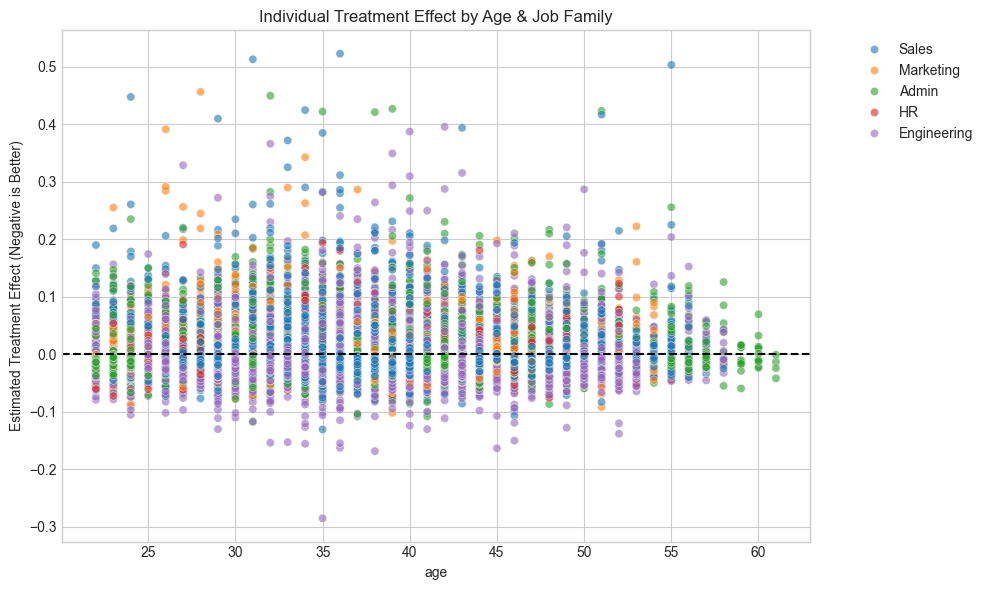


SUCCESS: Causal Inference tasks completed.


In [3]:
# ==========================================
# Task 2-3: 施策の因果推論 (Causal Inference) - 修正完了版
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
# ★修正点: ClassifierではなくRegressor（確率推定用）のみを使う
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif' 

print("Libraries loaded.")

# 2. データの読み込み
# ------------------------------------------
try:
    df = pd.read_csv('../data/simulated_hr_data.csv')
except FileNotFoundError:
    df = pd.read_csv('data/simulated_hr_data.csv')

print(f"Data Loaded: {df.shape}")

# 3. 前処理 (ID列削除)
# ------------------------------------------
df_for_analysis = df.drop(columns=['employee_id', 'month'])
df_encoded = pd.get_dummies(df_for_analysis, drop_first=True)
df_encoded = df_encoded.dropna()

print(f"Encoded Data Shape: {df_encoded.shape}")

# ---------------------------------------------------------
# 分析1: 傾向スコア（Propensity Score）による効果検証
# ---------------------------------------------------------
print("\n=== Analysis 1: Propensity Score Analysis ===")

T = df_encoded['training_participation']
Y = df_encoded['attrition_flag']
drop_cols_for_X = ['training_participation', 'attrition_flag', 'salary_change_flag']
X = df_encoded.drop(columns=drop_cols_for_X)

# 1. 傾向スコア算出
ps_model = LogisticRegression(random_state=42, max_iter=1000)
ps_model.fit(X, T)
ps_score = ps_model.predict_proba(X)[:, 1]

# 分布可視化
plt.figure(figsize=(10, 6))
sns.kdeplot(ps_score[T==1], label='Treated (Training)', fill=True, color='blue', alpha=0.3)
sns.kdeplot(ps_score[T==0], label='Control (No Training)', fill=True, color='red', alpha=0.3)
plt.title('Propensity Score Distribution')
plt.xlabel('Probability of Participating in Training')
plt.legend()
plt.show()

# 2. ATE算出
weight = T / ps_score + (1 - T) / (1 - ps_score)
ate = np.mean(weight * T * Y) - np.mean(weight * (1 - T) * Y)

print(f"推定された因果効果 (ATE): {ate:.4f}")
print("解釈: 研修に参加することで、離職率は 約 {:.2f}% ポイント変化する".format(ate * 100))


# ---------------------------------------------------------
# 分析2: Causal Forest による異質性分析 (Who benefits most?)
# ---------------------------------------------------------
print("\n=== Analysis 2: Heterogeneity with Causal Forest ===")
print("Calculating individual treatment effects (CATE)... This may take 1-2 minutes.")

# ★修正点: model_y, model_t を RandomForestRegressor に変更
# これにより確率（連続値）として計算が行われ、エラーが回避されます
cf = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    random_state=42
)

# 学習
cf.fit(Y, T, X=X)

# CATE推定
cate = cf.effect(X)

# 結果格納
df_res = df.copy()
df_res['cate'] = cate

# 効果が高い層の特徴
print("\n--- 研修効果が高い層 (Top Beneficiaries) ---")
display(df_res.sort_values('cate').head(5)[['age', 'job_family', 'performance_score', 'cate']])

# 可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='cate', hue='job_family', data=df_res, alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title('Individual Treatment Effect by Age & Job Family')
plt.ylabel('Estimated Treatment Effect (Negative is Better)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nSUCCESS: Causal Inference tasks completed.")